<a href="https://colab.research.google.com/github/Yagr49/Photocatalyst_NN/blob/Photocatal/notebooks/optimization/Optuna_Metal_complexes_and_Organic_compounds_SLATM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
# !!!!!!!!!!!!!Need V100 for appropriate time running!!!!!!!!!!!

In [ ]:
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install shap
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
import catboost
import numpy as np
import optuna
import pandas as pd
import xgboost
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Target Dataset of organic compound dataset


In [ ]:
start_db = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Target_dataset/Organic_compound_final_dataset.csv') # load target of organic compounds dataset

In [ ]:
 # slice target value
change_nm = start_db['Absorption max (nm)']
change_nm_em = start_db['Emission max (nm)']
change_y = start_db['Quantum yield']

In [ ]:
#add naming for columns for SLATM
comp = [f'SLATM_{i}' for i in range(14461)]
solv = [f'SLATM_solv_{i}' for i in range(4108)]
full = np.append(comp,solv)

# Absorption SLATM metal complex dataset

In [ ]:
tda_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_organic_compounds.csv')
tda_metal = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_metal_complex.csv')
SLATM_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Metal_complexes_descriptors/SLATM_organic_compound_with_solv_metal_inf.csv')
SLATM_metal = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Metal_complexes_descriptors/SLATM_metal_complexes_with_solv.csv')

In [ ]:
start_metal = pd.read_excel('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Target_dataset/Metal_complexes_dataset.xlsx')
start_metal

,Name,Absorption_nm,Emission_nm,Solvent,Lifetime_ns,Molecular_Mass
0,C20H8O5Br4,520,549.0,CC#N,2.66,647.89
1,C20H12O5,498,517.0,CC#N,4.70,332.31
2,C20H4Cl4I4O5,559,573.0,CCO,0.50,973.67
3,C28H31N2O3+,542,564.0,CCO,2.45,443.56
4,C26H30N4O10,443,524.0,CC#N,5.70,558.54
...,...,...,...,...,...,...
94,PtC17NH17O3,420,543.0,CC#N,11600000.00,478.40
95,CeSi6C25N5H68,423,NaN,NaN,67000.00,NaN
96,CeSi6C31N5H76,423,NaN,NaN,61000.00,NaN
97,WC55N4H46O4,407,608.0,C(Cl)Cl,4600000.00,1010.82


In [ ]:
change_nm_m = start_metal['Absorption_nm']

In [ ]:
SLATM_tda_db_abs = (
    pd.concat(
        [
            SLATM_full,
            tda_full,
            pd.DataFrame({"Absorption": change_nm}),
            pd.DataFrame(start_db["Molecular weight (g mol-1)"]),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)


In [ ]:
SLATM_tda_db_abs_m = (
    pd.concat(
        [
            SLATM_metal,
            tda_metal,
            pd.DataFrame({"Absorption": change_nm_m}),
            pd.DataFrame({"Molecular weight (g mol-1)": start_metal["Molecular_Mass"]}),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)

In [ ]:
x_train_abs, x_test_abs, _, _ = train_test_split(SLATM_tda_db_abs_m, SLATM_tda_db_abs_m, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
SLATM_Abs_2 = SLATM_tda_db_abs.append(x_train_abs.dropna())
SLATM_Abs_2 = SLATM_Abs_2.append(x_train_abs.dropna())
SLATM_Abs_2 = SLATM_Abs_2.append(x_train_abs.dropna())
scaler = StandardScaler()
scaler.fit(SLATM_Abs_2.loc[:, SLATM_Abs_2.columns != 'Absorption'])
train = scaler.transform(SLATM_Abs_2.loc[:, SLATM_Abs_2.columns != 'Absorption'])
y = np.log(SLATM_Abs_2['Absorption'])

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
x_test_abs = x_test_abs.dropna()
x_metal = scaler.transform(x_test_abs.loc[:, x_test_abs.columns != 'Absorption'])
y_metal = np.log(x_test_abs['Absorption'])
np.array(y_metal)

array([6.02102335, 5.91889385, 6.04025471, 5.88332239, 6.00635316,
       6.09807428, 6.07534603, 5.94542061, 6.05208917, 6.25382881])

In [ ]:
cat_metal_abs = catboost.CatBoostRegressor(random_seed=42, task_type="GPU",
                           devices='0:1',iterations=20000, od_type='IncToDec',od_pval = 1e-4) #od_type='IncToDec')
rng = np.random.RandomState(42)
cat_metal_abs.fit(train,y)
y_pred = cat_metal_abs.predict(x_metal)


In [ ]:
print(f'MRE : {mean_absolute_percentage_error(np.exp(y_metal), np.exp(y_pred))}')
print(f'MAE : {mean_absolute_error(np.exp(y_metal), np.exp(y_pred))}')
print(f'RMSE : {mean_squared_error(np.exp(y_metal), np.exp(y_pred), squared=False)}')

MRE : 0.021091255637981653
MAE : 54.55703777088844
RMSE : 65.340858204533


# Emission SLATM metal dataset


In [ ]:
tda_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_organic_compounds.csv') #load topologies feautre for rorganic compound
tda_metal = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_metal_complex.csv') # load topologiees feature for metal complex
SLATM_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Metal_complexes_descriptors/SLATM_organic_compound_with_solv_metal_inf.csv') #load SLATM of organic compound update for metall complex
SLATM_metal = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Metal_complexes_descriptors/SLATM_metal_complexes_with_solv.csv') #load SLATM for metall complex

In [ ]:
start_metal = pd.read_excel('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Target_dataset/Metal_complexes_dataset.xlsx') # load targets for metal complex
start_metal

,Name,Absorption_nm,Emission_nm,Solvent,Lifetime_ns,Molecular_Mass
0,C20H8O5Br4,520,549.0,CC#N,2.66,647.89
1,C20H12O5,498,517.0,CC#N,4.70,332.31
2,C20H4Cl4I4O5,559,573.0,CCO,0.50,973.67
3,C28H31N2O3+,542,564.0,CCO,2.45,443.56
4,C26H30N4O10,443,524.0,CC#N,5.70,558.54
...,...,...,...,...,...,...
94,PtC17NH17O3,420,543.0,CC#N,11600000.00,478.40
95,CeSi6C25N5H68,423,NaN,NaN,67000.00,NaN
96,CeSi6C31N5H76,423,NaN,NaN,61000.00,NaN
97,WC55N4H46O4,407,608.0,C(Cl)Cl,4600000.00,1010.82


In [ ]:
change_nm_em_m = start_metal['Emission_nm']

In [ ]:
SLATM_tda_db_em = (
    pd.concat(
        [
            SLATM_full,
            tda_full,
            pd.DataFrame({"Emission": change_nm_em}),
            pd.DataFrame(start_db["Molecular weight (g mol-1)"]),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)

In [ ]:
SLATM_tda_db_em_m = (
    pd.concat(
        [
            SLATM_metal,
            tda_metal,
            pd.DataFrame({"Emission": change_nm_em_m}),
            pd.DataFrame({"Molecular weight (g mol-1)": start_metal["Molecular_Mass"]}),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)

In [ ]:
x_train_em, x_test_em, _, _ = train_test_split(SLATM_tda_db_em_m, SLATM_tda_db_em_m, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
SLATM_EM_2 = SLATM_tda_db_em.append(x_train_em.dropna())
SLATM_EM_2 = SLATM_EM_2.append(x_train_em.dropna())
SLATM_EM_2 = SLATM_EM_2.append(x_train_em.dropna())
scaler = StandardScaler()
scaler.fit(SLATM_EM_2.loc[:, SLATM_EM_2.columns != 'Emission'])
train = scaler.transform(SLATM_EM_2.loc[:, SLATM_EM_2.columns != 'Emission'])
y = np.log(SLATM_EM_2['Emission'])

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
x_test_em = x_test_em.dropna()
x_metal = scaler.transform(x_test_em.loc[:, x_test_em.columns != 'Emission'])
y_metal = np.log(x_test_em['Emission'])
np.array(y_metal)

array([6.15909539, 6.228511  , 6.14203741, 6.41181827, 6.2441669 ,
       6.50727771, 6.35610766, 6.23244802, 6.3630281 , 6.30809844])

In [ ]:
cat_em = catboost.CatBoostRegressor(random_seed=42, task_type="GPU",
                           devices='0:1',iterations=20000, od_type='IncToDec',od_pval = 1e-4)
cat_em.fit(train,y)
y_pred = cat_em.predict(x_metal)


Выходные данные были обрезаны до нескольких последних строк (5000).
15000:	learn: 0.0592799	total: 39m 19s	remaining: 13m 6s
15001:	learn: 0.0592798	total: 39m 19s	remaining: 13m 6s
15002:	learn: 0.0592796	total: 39m 20s	remaining: 13m 6s
15003:	learn: 0.0592796	total: 39m 20s	remaining: 13m 5s
15004:	learn: 0.0592792	total: 39m 20s	remaining: 13m 5s
15005:	learn: 0.0592791	total: 39m 20s	remaining: 13m 5s
15006:	learn: 0.0592790	total: 39m 20s	remaining: 13m 5s
15007:	learn: 0.0592789	total: 39m 20s	remaining: 13m 5s
15008:	learn: 0.0592789	total: 39m 20s	remaining: 13m 5s
15009:	learn: 0.0592787	total: 39m 21s	remaining: 13m 4s
15010:	learn: 0.0592786	total: 39m 21s	remaining: 13m 4s
15011:	learn: 0.0592786	total: 39m 21s	remaining: 13m 4s
15012:	learn: 0.0592783	total: 39m 21s	remaining: 13m 4s
15013:	learn: 0.0592776	total: 39m 21s	remaining: 13m 4s
15014:	learn: 0.0592769	total: 39m 21s	remaining: 13m 4s
15015:	learn: 0.0592748	total: 39m 22s	remaining: 13m 3s
15016:	learn: 0.0592

In [ ]:
print(f'MRE : {mean_absolute_percentage_error(np.exp(y_metal), np.exp(y_pred))}')
print(f'MAE : {mean_absolute_error(np.exp(y_metal), np.exp(y_pred))}')
print(f'RMSE : {mean_squared_error(np.exp(y_metal), np.exp(y_pred), squared=False)}')

MRE : 0.1163273640949398
MAE : 62.63644130516085
RMSE : 67.76989037293002


# Absorption Optuna XGBoost for organic compound

In [ ]:
tda_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_organic_compounds.csv') #downloas SLATM_dataset for original organic compounds
SLATM_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Organic_compounds_descriptors/SLATM_organic_compounds_with_solv.csv')

In [ ]:
SLATM_full = SLATM_full.fillna(0.0) #fix NaN value

In [ ]:
SLATM_tda_db_abs = ( # preparing full dataset
    pd.concat(
        [
            SLATM_full,
            tda_full,
            pd.DataFrame({"Absorption": change_nm}),
            pd.DataFrame(start_db["Molecular weight (g mol-1)"]),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)


In [ ]:
# train/test split for absorption
x_train_abs, x_test_abs, y_train_abs, y_test_abs = train_test_split(SLATM_tda_db_abs.loc[:, SLATM_tda_db_abs.columns != 'Absorption'], SLATM_tda_db_abs['Absorption'], test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
scaler.fit(x_train_abs)
y_train_abs = np.log(y_train_abs)
y_test_abs = np.log(y_test_abs)
x_train_abs = pd.DataFrame(scaler.transform(x_train_abs))
x_test_abs = pd.DataFrame(scaler.transform(x_test_abs))
print('Scalling finished')

Scalling finished


In [ ]:
#get parametrs for xgboost
import optuna
from optuna.samplers import RandomSampler

#
def objective(trial):
    param = {
 # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 5),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 5),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    model = xgboost.XGBRegressor(
        **param,
        n_jobs=-1,
        tree_method='hist', device = 'cuda', missing = np.inf
    )
    model.fit(x_train_abs, y_train_abs)
    y_pred = model.predict(x_test_abs)
    return mean_squared_error(np.exp(y_test_abs), np.exp(y_pred))
    model.fit(x_train_abs, y_train_abs)
    y_pred = model.predict(x_test_abs)
    return mean_squared_error(np.exp(y_test_abs), np.exp(y_pred))


# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=1)
study_xgb_abs = optuna.create_study(
    study_name="xgb_abs", direction="minimize", sampler=RandomSampler(42)
)
study_xgb_abs.optimize(objective, n_trials=15)
print("Number of finished trials: ", len(study_xgb_abs.trials))
print("Best trial:")
trial_xgb_abs = study_xgb_abs.best_trial
print("  Value: ", trial_xgb_abs.value)
print("  Params: ")
for key, value in trial_xgb_abs.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#make Absorption xgboost model for organic compounds dataset
model = xgboost.XGBRegressor(**{'random_state':42,
                                'n_estimators': 10000,
                                'max_depth': 13,
                                'subsample': 0.8,
                                'min_child_weight': 60,
                                'learning_rate': 0.01,
                                'colsample_bytree': 0.3,
                                'alpha': 0.0048280425192712886,
                                'lambda': 0.105260377776104},
                                n_jobs=-1,
                                tree_method='hist', device = 'cuda', missing = np.inf
                            )
model.fit(x_train_abs, y_train_abs)
y_pred = model.predict(x_test_abs)

[11:44:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



In [ ]:
print(f'MRE : {mean_absolute_percentage_error(np.exp(y_test_abs), np.exp(y_pred))}')
print(f'MAE : {mean_absolute_error(np.exp(y_test_abs), np.exp(y_pred))}')
print(f'RMSE: {mean_squared_error(np.exp(y_test_abs), np.exp(y_pred), squared=False)}')
correlation, _ = stats.pearsonr(y_test_abs, y_pred)
print(f'Pearson correlation : {correlation}')

MRE : 0.04233860480417574
MAE : 18.100540621130172
RMSE: 29.724519080818567
Pearson correlation : 0.9491549752759094


## Error Distribution Absorption

100%|██████████| 4048/4048 [12:44<00:00,  5.30it/s]


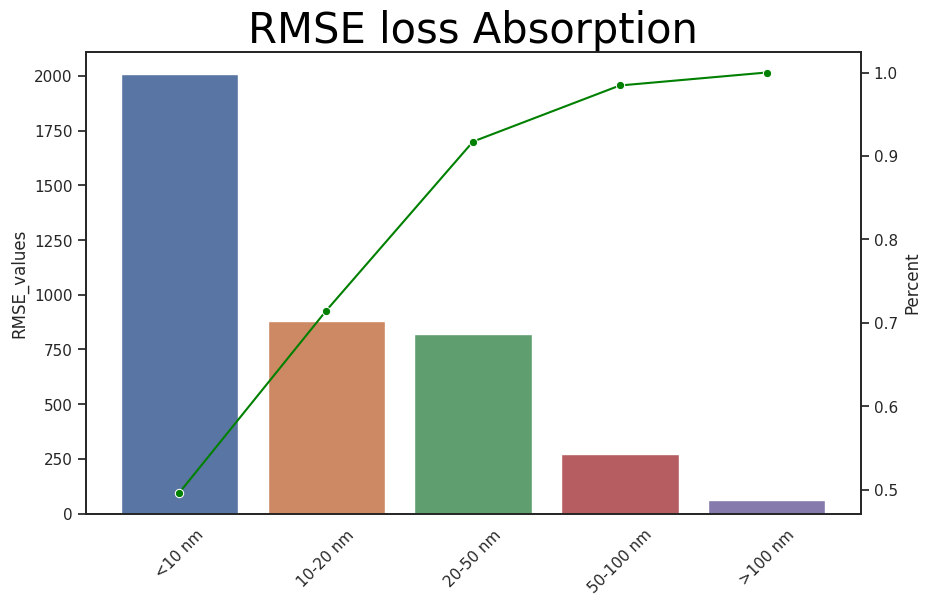

In [ ]:
#error distribution
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
index = x_test_abs.index
dt_list = []
for i in tqdm(index):
    y_pred = model.predict(np.array(x_test_abs.loc()[i]).reshape(1,-1))
    temp_mse = np.sqrt((np.exp(list(y_test_abs)[i]) - np.exp(y_pred))**2)
    dt_list.append(float(temp_mse))
list_10 = len([i for i in dt_list if i<10])
list_20 = len([i for i in dt_list if 10<i<20])
list_50 = len([i for i in dt_list if 20<i<50])
list_60 = len([i for i in dt_list if 50<i<100])
list_100 = len([i for i in dt_list if i>100])
sns.set_theme(style='white')
data = ['<10 nm','10-20 nm','20-50 nm','50-100 nm','>100 nm']
plt.figure(figsize=(2*5, 2*3))
ax = sns.barplot(x=list(data), y=[list_10,list_20,list_50,list_60,list_100]) #data=data)
plt.title('RMSE loss Absorption', fontsize=30,
          color="black")
plt.ylabel('RMSE_values')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax2 = ax.twinx()
ax2 = sns.lineplot(x=data, y=[list_10/len(y_test_abs),(list_10+list_20)/len(y_test_abs),(list_10+list_20+list_50)/len(y_test_abs),(list_10+list_20+list_50+list_60)/len(y_test_abs),(list_10+list_20+list_50+list_60+list_100)/len(y_test_abs)], color='green', marker='o')
ax2.set_ylabel('Percent')
#if you want to download picture uncomment below code
#plt.savefig('/content/drive/MyDrive/XGB_RMSE_dist_for_Absorption_SLATM.png',
#               dpi=300,
#               bbox_inches='tight')

## Correlation Absorption

In [ ]:
#correlation on test dataset of organic compounds
from scipy import stats
import plotly.graph_objects as go
сat_reg_model_pred = model.predict(x_test_abs)
slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(сat_reg_model_pred, y_test_abs)
line_test = slope_test * сat_reg_model_pred + intercept_test

cat_reg_error_plot = go.Figure()

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=line_test,\
                                       mode='lines', line_width=5, marker_color='green',\
                                        marker_symbol='triangle-down',
                                       name='Test set trend line: R\u00B2 = ' + str(round(r_value_test**2, 2))))

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=y_test_abs,\
                                       mode='markers', marker_size=4.5, marker_color='blue', \
                                        marker_symbol='circle-open-dot',
                                       name='Test set prediction'))

cat_reg_error_plot.update_layout(
    width = 1000,
    height=600,
    title_text='XGBoost values: Absorption',
    xaxis_title="Predicted values",
    yaxis_title="Actual values",
    font=dict(
        family="Ubuntu",
        size=14,
        color="Black"
    )
)

cat_reg_error_plot.update_layout(
    legend=dict(
        title = 'Absorption',
        title_font_family="Ubuntu",
        font=dict(
            family="Ubuntu",
            size=14,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    )
)
cat_reg_error_plot.show()

## SHAP Absorption for organic compounds

In [ ]:
#adding topoligies features names for SHAP on organic compound dataset
full_name_coll = np.append(full,tda_full.columns)
full_name_coll

In [ ]:
#prepare SHAP
import shap
explainer = shap.TreeExplainer(model)

In [ ]:
#because shap delete argument about np.inf compound we drop sample from test data
sum_fail_index = []
for i in range(1,4048):
  in_=[]
  x = np.array(x_test_abs.loc[[i]]).squeeze()
  for j in x:
    if j>100000:
      in_.append(j)
  if len(in_)>0:
    print(f'{i} is wrong')
  else:
    sum_fail_index.append(i)


In [ ]:
x_test_abs_shap=x_test_abs.loc[sum_fail_index]
x_test_abs_shap

,0,1,2,3,4,5,6,7,8,9,...,18584,18585,18586,18587,18588,18589,18590,18591,18592,18593
1,-0.380858,-0.654751,-0.337963,0.434112,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.208894
2,-0.380858,-0.708501,-0.567495,-0.786454,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,2.852710,-0.797239,-0.538092,-2.426194,-0.302148,-0.379984,-0.915134,-0.393162,-0.449769,-0.224092
3,0.893497,3.215224,2.301653,1.044396,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.343545
4,-0.380858,-0.493502,-0.797027,-0.786454,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.106514,1.710801,2.320713,-0.317037,-0.302148,-0.379984,0.693198,-0.393162,-0.449769,0.311513
5,3.442207,1.495235,0.350632,-1.396738,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.571070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,0.893497,-0.547252,-0.337963,-0.176171,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.252383,0.183262,-0.400724,-0.034328,0.007664,-0.379984,0.605236,0.669487,-0.449769,-0.315679
4044,4.716562,1.333986,0.752313,-0.176171,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.401286
4045,-0.380858,-0.654751,-1.026559,1.044396,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.280339,-0.797239,-0.538092,-0.614785,-0.302148,-0.379984,0.315923,-0.393162,-0.449769,-0.286410
4046,-0.380858,-0.601001,-0.452729,0.434112,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.364848,-0.797239,-0.538092,-0.689759,-0.302148,-0.379984,-0.649809,-0.393162,-0.449769,-0.896761


In [ ]:
shap_values = explainer.shap_values(x_test_abs_shap)

In [ ]:
x_test_abs_shap_1 = pd.DataFrame(np.array(x_test_abs_shap),columns = full_name_coll)

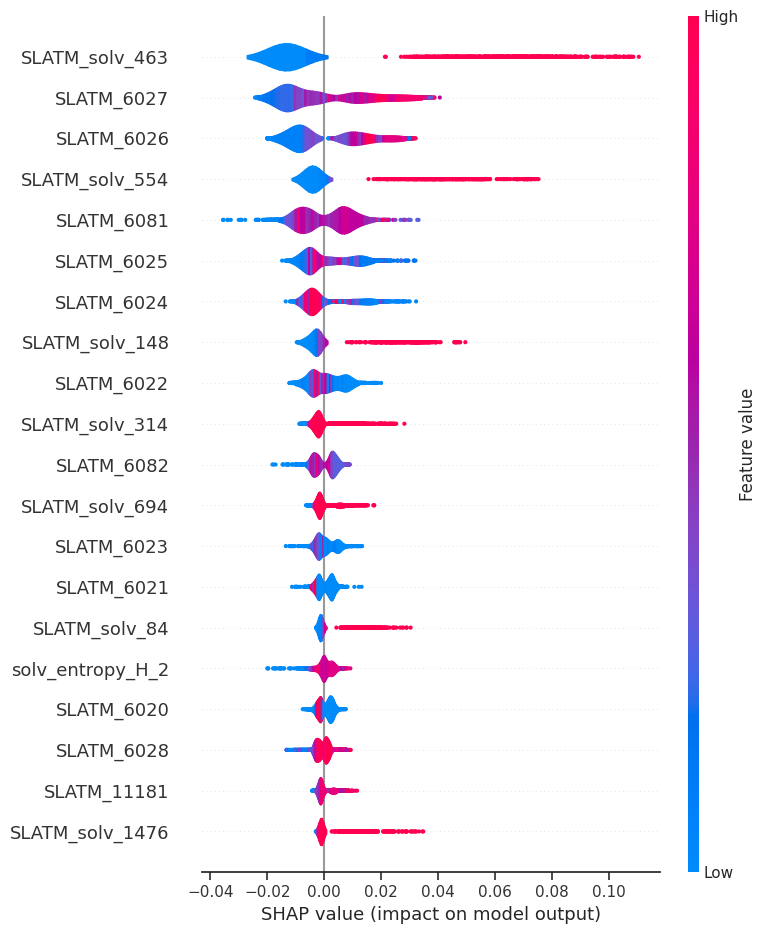

In [ ]:
shap.summary_plot(shap_values, x_test_abs_shap_1, plot_type="violin")

#Emission Optuna XGBoost for organic compound

In [ ]:
tda_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_organic_compounds.csv') #downloas SLATM_dataset for original organic compounds
SLATM_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Organic_compounds_descriptors/SLATM_organic_compounds_with_solv.csv')
SLATM_full = SLATM_full.fillna(0.0) #fix NaN value

In [ ]:
SLATM_tda_db_em = ( # adding topologies feature
    pd.concat(
        [
            SLATM_full,
            tda_full,
            pd.DataFrame({"Emission": change_nm_em}),
            pd.DataFrame(start_db["Molecular weight (g mol-1)"]),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)

In [ ]:
#make train/test split
x_train_em, x_test_em, y_train_em, y_test_em = train_test_split(SLATM_tda_db_em.loc[:, SLATM_tda_db_em.columns != 'Emission'], SLATM_tda_db_em['Emission'], test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
scaler.fit(x_train_em)
y_train_em = np.log(y_train_em)
y_test_em = np.log(y_test_em)
x_train_em = pd.DataFrame(scaler.transform(x_train_em))
x_test_em = pd.DataFrame(scaler.transform(x_test_em))
print('Scalling finished')

Scalling finished


In [ ]:
#get pararmetrs for xgboost
import optuna
from optuna.samplers import RandomSampler


def objective(trial):
    param = {
 # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 5),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 5),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    model = xgboost.XGBRegressor(
        **param,
        n_jobs=-1,
        tree_method='hist', device = 'cuda', missing = np.inf
    )
    model.fit(x_train_em, y_train_em)
    y_pred = model.predict(x_test_em)
    return mean_squared_error(np.exp(y_test_em), np.exp(y_pred))


study_xgb_em = optuna.create_study(
    study_name="xgb_em", direction="minimize", sampler=RandomSampler(42)
)
study_xgb_em.optimize(objective, n_trials=15)
print("Number of finished trials: ", len(study_xgb_em.trials))
print("Best trial:")
trial_xgb_em = study_xgb_em.best_trial
print("  Value: ", trial_xgb_em.value)
print("  Params: ")
for key, value in trial_xgb_em.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#make Emissiom xgboost model for organic compounds dataset
from sklearn.neural_network import MLPRegressor
import xgboost
model_em = xgboost.XGBRegressor(
        **{'lambda': 0.105260377776104,
    'alpha': 0.0048280425192712886,
    'colsample_bytree': 0.3,
    'subsample': 0.8,
    'learning_rate': 0.01,
    'max_depth': 13,
    'random_state': 42,
    'min_child_weight': 60},
    n_estimators = 10000,
        n_jobs=-1,
        tree_method='hist', device = 'cuda', missing = np.inf
    )
model_em.fit(x_train_em, y_train_em)
y_pred = model_em.predict(x_test_em)

In [ ]:
print(f'MRE : {mean_absolute_percentage_error(np.exp(y_test_em), np.exp(y_pred))}')
print(f'MAE : {mean_absolute_error(np.exp(y_test_em), np.exp(y_pred))}')
print(f'RMSE: {mean_squared_error(np.exp(y_test_em), np.exp(y_pred), squared=False)}')
correlation, _ = stats.pearsonr(y_test_em, y_pred)
print(f'Pearson correlation : {correlation}')

MRE : 0.047610376629036257
MAE : 23.919983002471074
RMSE: 35.976459947633174
Pearson correlation : 0.9176706866422802


## Error Distribution Emission

100%|██████████| 4048/4048 [13:13<00:00,  5.10it/s]


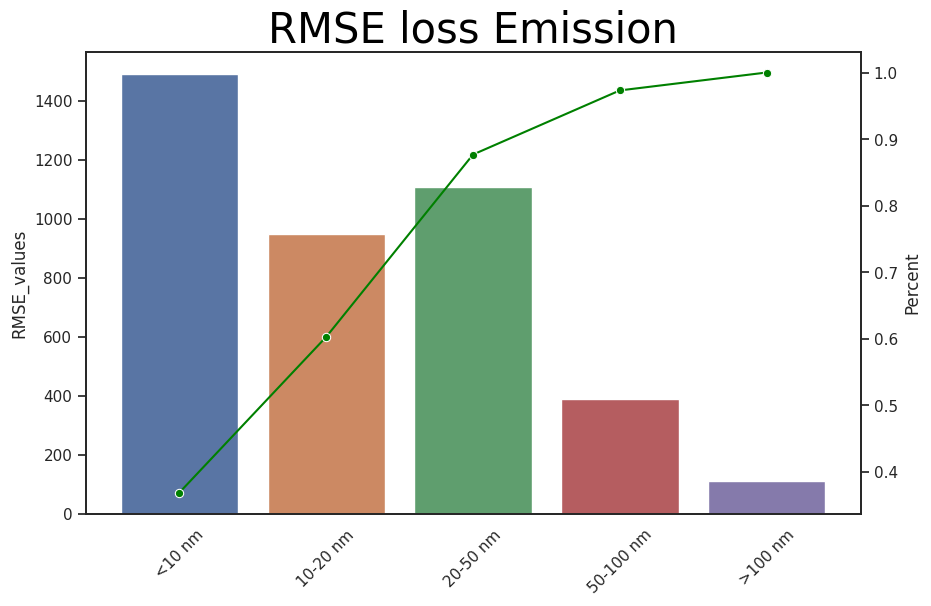

In [ ]:
#error distribution
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
index = x_test_em.index
dt_list = []
for i in tqdm(index):
    y_pred = model_em.predict(np.array(x_test_em.loc()[i]).reshape(1,-1))
    temp_mse = np.sqrt((np.exp(list(y_test_em)[i]) - np.exp(y_pred))**2)
    dt_list.append(float(temp_mse))
list_10 = len([i for i in dt_list if i<10])
list_20 = len([i for i in dt_list if 10<i<20])
list_50 = len([i for i in dt_list if 20<i<50])
list_60 = len([i for i in dt_list if 50<i<100])
list_100 = len([i for i in dt_list if i>100])
sns.set_theme(style='white')
data = ['<10 nm','10-20 nm','20-50 nm','50-100 nm','>100 nm']
plt.figure(figsize=(2*5, 2*3))
ax = sns.barplot(x=list(data), y=[list_10,list_20,list_50,list_60,list_100]) #data=data)
plt.title('RMSE loss Emission', fontsize=30,
          color="black")
plt.ylabel('RMSE_values')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax2 = ax.twinx()
ax2 = sns.lineplot(x=data, y=[list_10/len(y_test_em),(list_10+list_20)/len(y_test_em),(list_10+list_20+list_50)/len(y_test_em),(list_10+list_20+list_50+list_60)/len(y_test_em),(list_10+list_20+list_50+list_60+list_100)/len(y_test_em)], color='green', marker='o')
ax2.set_ylabel('Percent')
#if you want download picture
#plt.savefig('/content/drive/MyDrive/XGB_RMSE_dist_for_EM_SLATM.png',
#               dpi=300,
#               bbox_inches='tight')

## Correlation Emission

In [ ]:
#correlation on test dataset of organic compounds
from scipy import stats
import plotly.graph_objects as go
сat_reg_model_pred = model_em.predict(x_test_em)
slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(сat_reg_model_pred, y_test_em)
line_test = slope_test * сat_reg_model_pred + intercept_test

cat_reg_error_plot = go.Figure()

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=line_test,\
                                       mode='lines', line_width=5, marker_color='green',\
                                        marker_symbol='triangle-down',
                                       name='Test set trend line: R\u00B2 = ' + str(round(r_value_test**2, 2))))

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=y_test_em,\
                                       mode='markers', marker_size=4.5, marker_color='blue', \
                                        marker_symbol='circle-open-dot',
                                       name='Test set prediction'))

cat_reg_error_plot.update_layout(
    width = 1000,
    height=600,
    title_text='XGBoost values: Emission',
    xaxis_title="Predicted values",
    yaxis_title="Actual values",
    font=dict(
        family="Ubuntu",
        size=14,
        color="Black"
    )
)

cat_reg_error_plot.update_layout(
    legend=dict(
        title = 'Emission',
        title_font_family="Ubuntu",
        font=dict(
            family="Ubuntu",
            size=14,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    )
)
cat_reg_error_plot.show()

## SHAP Emission for organic compound

In [ ]:
#adding topoligies features names for SHAP on organic compound dataset
full_name_coll = np.append(full,tda_full.columns)
full_name_coll

In [ ]:
#because shap delete argument about np.inf compound we drop sample from test data
sum_fail_index = []
for i in range(1,4048):
  in_=[]
  x = np.array(x_test_em.loc[[i]]).squeeze()
  for j in x:
    if j>100000:
      in_.append(j)
  if len(in_)>0:
    print(f'{i} is wrong')
  else:
    sum_fail_index.append(i)

In [ ]:
x_test_em_shap=x_test_em.loc[sum_fail_index]
x_test_em_shap

,0,1,2,3,4,5,6,7,8,9,...,18584,18585,18586,18587,18588,18589,18590,18591,18592,18593
1,-0.380858,-0.654751,-0.337963,0.434112,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.208894
2,-0.380858,-0.708501,-0.567495,-0.786454,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,2.852710,-0.797239,-0.538092,-2.426194,-0.302148,-0.379984,-0.915134,-0.393162,-0.449769,-0.224092
3,0.893497,3.215224,2.301653,1.044396,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.343545
4,-0.380858,-0.493502,-0.797027,-0.786454,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.106514,1.710801,2.320713,-0.317037,-0.302148,-0.379984,0.693198,-0.393162,-0.449769,0.311513
5,3.442207,1.495235,0.350632,-1.396738,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.571070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,0.893497,-0.547252,-0.337963,-0.176171,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.252383,0.183262,-0.400724,-0.034328,0.007664,-0.379984,0.605236,0.669487,-0.449769,-0.315679
4044,4.716562,1.333986,0.752313,-0.176171,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,0.969729,-0.797239,-0.538092,1.769968,-0.302148,-0.379984,-0.949495,-0.393162,-0.449769,-0.401286
4045,-0.380858,-0.654751,-1.026559,1.044396,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.280339,-0.797239,-0.538092,-0.614785,-0.302148,-0.379984,0.315923,-0.393162,-0.449769,-0.286410
4046,-0.380858,-0.601001,-0.452729,0.434112,0.0,-7.702483e-321,-2.777213e-311,-7.074670e-302,-1.459502e-292,-2.344877e-283,...,-0.364848,-0.797239,-0.538092,-0.689759,-0.302148,-0.379984,-0.649809,-0.393162,-0.449769,-0.896761


In [ ]:
x_test_em_shap_1 = pd.DataFrame(np.array(x_test_em_shap),columns = full_name_coll)

[09:43:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


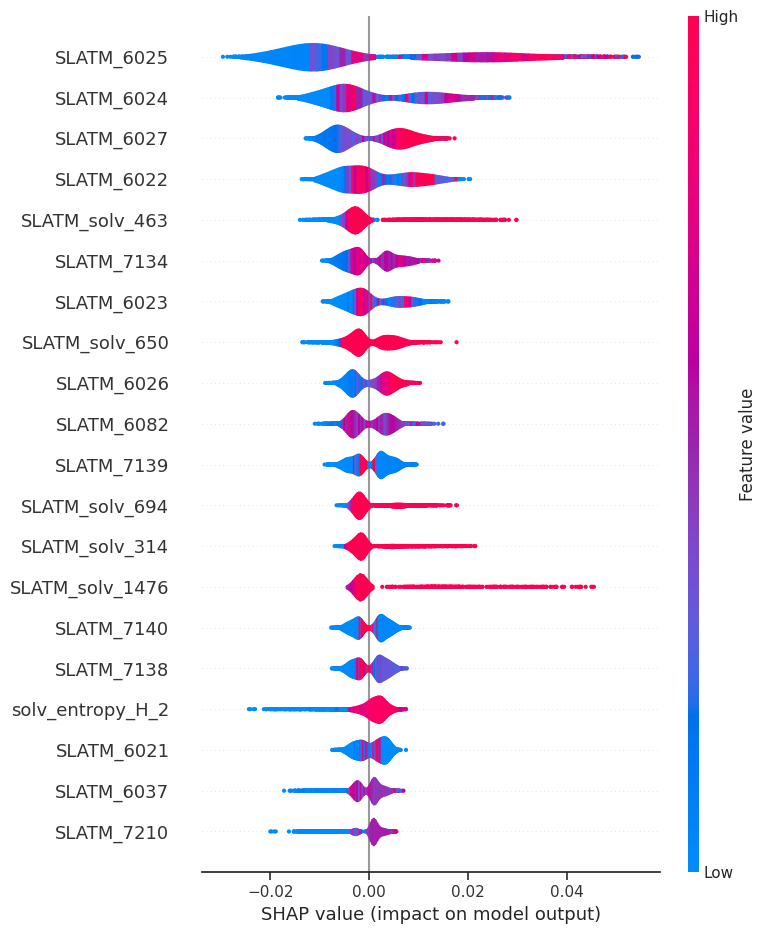

In [ ]:
explainer = shap.TreeExplainer(model_em)
shap_values = explainer.shap_values(x_test_em_shap)
shap.summary_plot(shap_values, x_test_em_shap_1, plot_type="violin")

# Quantumm yield CatBoost for organic compound

In [ ]:
tda_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_organic_compounds.csv') #downloas SLATM_dataset for original organic compounds
SLATM_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Organic_compounds_descriptors/SLATM_organic_compounds_with_solv.csv')
SLATM_full = SLATM_full.fillna(0.0) #fix NaN value

In [ ]:
SLATM_tda_db_y = ( # adding topologies feature
    pd.concat(
        [
            SLATM_full,
            tda_full,
            pd.DataFrame({"Quantum": change_y}),
            pd.DataFrame(start_db["Molecular weight (g mol-1)"]),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)

In [ ]:
#make train/test split
x_train_y, x_test_y, y_train_y, y_test_y = train_test_split(
    SLATM_tda_db_y.loc[:, SLATM_tda_db_y.columns != "Quantum"],
    SLATM_tda_db_y["Quantum"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
scaler = StandardScaler()
scaler.fit(x_train_y)
# y_train_y = np.log(y_train_y)
# y_test_y = np.log(y_test_y) because you have zero value target
x_train_y = pd.DataFrame(scaler.transform(x_train_y))
x_test_y = pd.DataFrame(scaler.transform(x_test_y))
print("Scalling finished")

Scalling finished


In [ ]:
model_y = catboost.CatBoostRegressor(iterations=20000,  random_seed=42,
                                     task_type="GPU", od_type='IncToDec',od_pval = 1e-4)
model_y.fit(x_train_y, y_train_y)
y_pred = model_y.predict(x_test_y)

Выходные данные были обрезаны до нескольких последних строк (5000).
15000:	learn: 0.1295708	total: 1h 11m 32s	remaining: 23m 50s
15001:	learn: 0.1295684	total: 1h 11m 33s	remaining: 23m 50s
15002:	learn: 0.1295664	total: 1h 11m 33s	remaining: 23m 50s
15003:	learn: 0.1295588	total: 1h 11m 33s	remaining: 23m 49s
15004:	learn: 0.1295515	total: 1h 11m 34s	remaining: 23m 49s
15005:	learn: 0.1295467	total: 1h 11m 34s	remaining: 23m 49s
15006:	learn: 0.1295463	total: 1h 11m 34s	remaining: 23m 48s
15007:	learn: 0.1295411	total: 1h 11m 35s	remaining: 23m 48s
15008:	learn: 0.1295407	total: 1h 11m 35s	remaining: 23m 48s
15009:	learn: 0.1295389	total: 1h 11m 35s	remaining: 23m 48s
15010:	learn: 0.1295387	total: 1h 11m 35s	remaining: 23m 47s
15011:	learn: 0.1295357	total: 1h 11m 36s	remaining: 23m 47s
15012:	learn: 0.1295314	total: 1h 11m 36s	remaining: 23m 47s
15013:	learn: 0.1295298	total: 1h 11m 36s	remaining: 23m 46s
15014:	learn: 0.1295265	total: 1h 11m 36s	remaining: 23m 46s
15015:	learn: 0.1

In [ ]:
print(f'MAE : {mean_absolute_error((y_test_y), (y_pred))}')
print(f'RMSE: {mean_squared_error((y_test_y), (y_pred), squared=False)}')
correlation, _ = stats.pearsonr(y_test_y, y_pred)
print(f'Pearson correlation : {correlation}')

MAE : 0.1296112316701525
RMSE: 0.17700964393342394
Pearson correlation : 0.729615941438412


##Error Distribution Quantum Yield

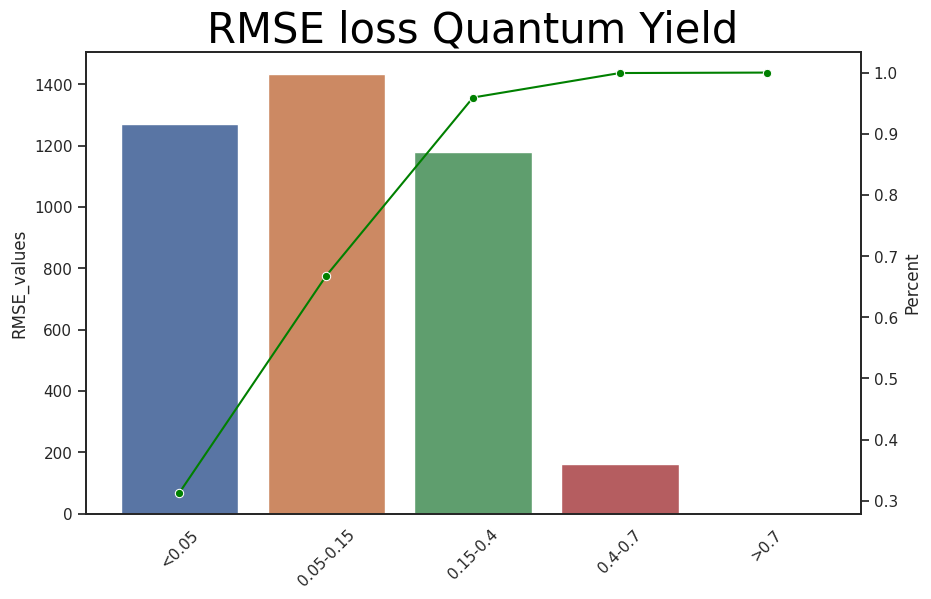

In [ ]:
#error distribution
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
index = x_test_y.index
dt_list = []
em_list = []
for i in tqdm(index):
    y_pred = model_y.predict(np.array(x_test_y.loc()[i]).reshape(1,-1))
    temp_mse = np.sqrt((list(y_test_y)[i] - y_pred)**2)
    dt_list.append(float(temp_mse))
list_10 = len([i for i in dt_list if i<0.05])
list_20 = len([i for i in dt_list if 0.05<i<0.15])
list_50 = len([i for i in dt_list if 0.15<i<0.4])
list_60 = len([i for i in dt_list if 0.4<i<0.7])
list_100 = len([i for i in dt_list if i>0.7])

sns.set_theme(style='white')
data = ['<0.05','0.05-0.15','0.15-0.4','0.4-0.7','>0.7']
plt.figure(figsize=(2*5, 2*3))
ax = sns.barplot(x=list(data), y=[list_10,list_20,list_50,list_60,list_100]) #data=data)
plt.title('RMSE loss Quantum Yield', fontsize=30,
          color="black")

plt.ylabel('RMSE_values')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax2 = ax.twinx()
ax2 = sns.lineplot(x=data, y=[list_10/len(y_test_y),(list_10+list_20)/len(y_test_y),(list_10+list_20+list_50)/len(y_test_y),(list_10+list_20+list_50+list_60)/len(y_test_y),(list_10+list_20+list_50+list_60+list_100)/len(y_test_y)], color='green', marker='o')
ax2.set_ylabel('Percent')
#if you want to download picture
#plt.savefig('/content/drive/MyDrive/CAT_RMSE_dist_for_Y_SLATM.png',
#               dpi=300,
#               bbox_inches='tight')

## Correlation Quantum yield

In [ ]:
#correlation on test dataset of organic compounds
from scipy import stats
import plotly.graph_objects as go
сat_reg_model_pred = model_y.predict(x_test_y)
slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(сat_reg_model_pred, y_test_y)
line_test = slope_test * сat_reg_model_pred + intercept_test

cat_reg_error_plot = go.Figure()

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=line_test,\
                                       mode='lines', line_width=5, marker_color='green',\
                                        marker_symbol='triangle-down',
                                       name='Test set trend line: R\u00B2 = ' + str(round(r_value_test**2, 2))))

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=y_test_y,\
                                       mode='markers', marker_size=4.5, marker_color='blue', \
                                        marker_symbol='circle-open-dot',
                                       name='Test set prediction'))

cat_reg_error_plot.update_layout(
    width = 1000,
    height=600,
    title_text='XGBoost values: Quantum Yield',
    xaxis_title="Predicted values",
    yaxis_title="Actual values",
    font=dict(
        family="Ubuntu",
        size=14,
        color="Black"
    )
)

cat_reg_error_plot.update_layout(
    legend=dict(
        title = 'Quantum Yield',
        title_font_family="Ubuntu",
        font=dict(
            family="Ubuntu",
            size=14,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    )
)
cat_reg_error_plot.show()

## SHAP Quantum yield for organic compound

In [ ]:
#adding topoligies features names for SHAP on organic compound dataset
full_name_coll = np.append(full,tda_full.columns)
full_name_coll

In [ ]:
sum_fail_index = []

for i in range(1,4048):
  in_=[]
  x = np.array(x_test_y.loc[[i]]).squeeze()
  for j in x:
    if j>100000:
      in_.append(j)
  if len(in_)>0:
    print(f'{i} is wrong')
  else:
    sum_fail_index.append(i)
x_test_y_shap=x_test_y.loc[sum_fail_index]
x_test_y_shap_1 = pd.DataFrame(np.array(x_test_y_shap),columns = full_name_coll)

346 is big dick
798 is big dick
932 is big dick
1244 is big dick
1616 is big dick
1694 is big dick
2528 is big dick
2903 is big dick
3050 is big dick
3390 is big dick


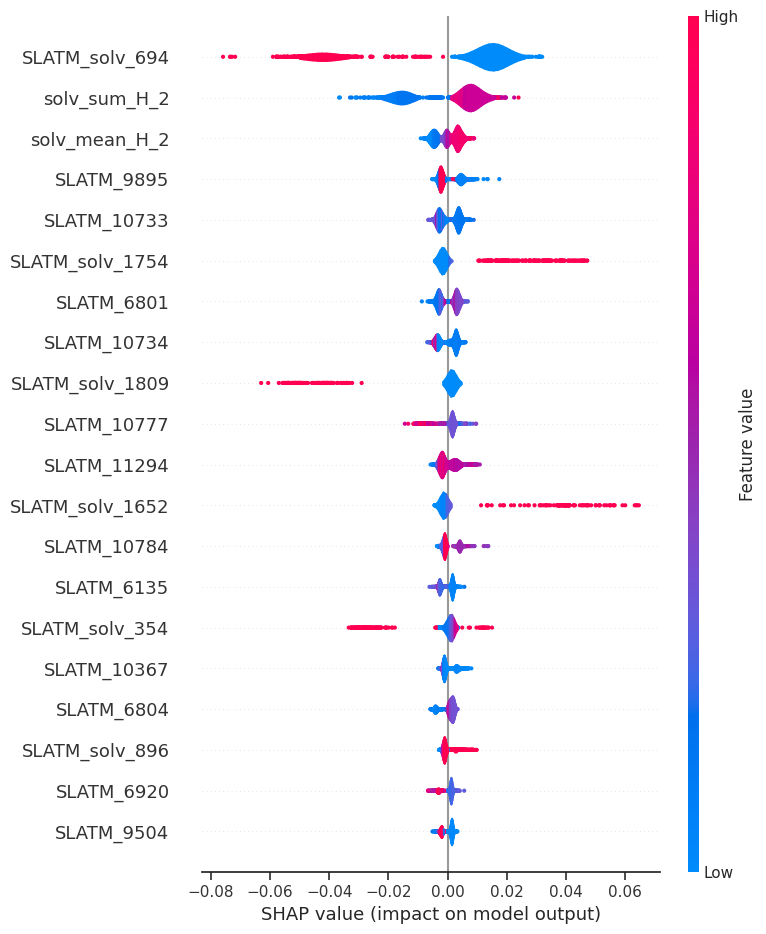

In [ ]:
explainer = shap.TreeExplainer(model_y)
shap_values = explainer.shap_values(x_test_y_shap)
shap.summary_plot(shap_values, x_test_y_shap_1, plot_type="violin")